# 1、Environmental plot

## 1.0 Load data

In [1]:
from matplotlib import pyplot as plt
from function import *
from function.global_varibles import *
import glob
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import numpy as np


df_analysis=pd.read_csv(r'data\US_data\df_merged_data_for_analysis.csv')
df_economic = pd.read_csv('data/US_data/df_economic.csv')
df_analysis


# 环境维度的变量
env_data = df_analysis[['lat', 'lon', 'predicted_prob','gmm_density','sample_type']].copy()

# 碳减排维度的变量

emission_data = df_analysis[['lat', 'lon', 'Expectation_net_benefit_adjust','area_m2']].copy()
emission_data = emission_data.rename(columns={'Expectation_net_benefit_adjust': 'Expectation_net_benefit'})

# 经济维度的变量
economic_2050 = df_economic[df_economic['analysis_year'] == 2050]
avg_npv = economic_2050.groupby(['lat', 'lon'])['net_npv_usd'].mean().reset_index().rename(columns={'net_npv_usd': 'avg_npv'})


# 合并所有变量
merged_data_for_plot = env_data.merge(emission_data, on=['lat', 'lon'], how='outer') \
                      .merge(avg_npv, on=['lat', 'lon'], how='outer')


                      

gogogo
✅ TensorFlow available
✅ scikeras available
✅ SHAP available


In [2]:
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO



us_nation = gpd.read_file(r'data\US_data\cb_2018_us_nation_5m.shp')
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')
us_counties = gpd.read_file('data/cb_2018_us_county_500k.shp')


us_nation_4326 = us_nation.to_crs('EPSG:4326')
us_states_4326 = us_states.to_crs('EPSG:4326')
us_counties_4326 = us_counties.to_crs('EPSG:4326')

# 2. 读取DEM并设置CRS（如果缺失）
dem = rioxarray.open_rasterio(r'figure\draw_shp\DEM.nc', masked=True)

# 检查DEM的CRS，如果缺失则手动设置
if dem.rio.crs is None:
    # 根据DEM数据的坐标范围判断，通常全球DEM使用EPSG:4326
    print("DEM CRS缺失，设置为EPSG:4326")
    dem = dem.rio.write_crs("EPSG:4326")

# 3. 确保US nation的CRS与DEM一致
if us_nation.crs != dem.rio.crs:
    print(f"转换US nation CRS从 {us_nation.crs} 到 {dem.rio.crs}")
    us_nation = us_nation.to_crs(dem.rio.crs)



# 4. 用us_nation精确裁剪DEM
print("开始裁剪DEM（使用us_nation）...")
dem_us = dem.rio.clip(us_nation.geometry.apply(mapping), us_nation.crs, drop=True)
print("DEM裁剪完成！")





DEM CRS缺失，设置为EPSG:4326
转换US nation CRS从 EPSG:4269 到 EPSG:4326
开始裁剪DEM（使用us_nation）...
DEM裁剪完成！


## 1.1 Help funciton

In [64]:

def _render_terrain(ax, dem_data, usa_bounds_main, transformer):
    """渲染地形"""
    qm = None
    dem_lon = dem_data.x.values
    dem_lat = dem_data.y.values
    lon_mask = (dem_lon >= usa_bounds_main['lon_min']) & (dem_lon <= usa_bounds_main['lon_max'])
    lat_mask = (dem_lat >= usa_bounds_main['lat_min']) & (dem_lat <= usa_bounds_main['lat_max'])
    
    if lon_mask.any() and lat_mask.any():
        lon_idx = np.where(lon_mask)[0]
        lat_idx = np.where(lat_mask)[0]
        
        # 抽稀栅格
        step_x = max(1, len(lon_idx)//1800)
        step_y = max(1, len(lat_idx)//900)
        lon_sub = lon_idx[::step_x]
        lat_sub = lat_idx[::step_y]
        elev = dem_data.squeeze().values[np.ix_(lat_sub, lon_sub)]

        mask = ~np.isnan(elev)
        if mask.any():
            lo = np.nanpercentile(elev, 35)
            elev[elev < lo] = np.nan

            # 地形配色
            terrain_colors = ListedColormap(["#ffffff", "#eef3ef", "#dfe8e0",
                                           "#d2ddcf", "#c7d1c1", "#b7c2af"])
            terrain_colors.set_bad((0, 0, 0, 0))
            qs = np.nanpercentile(elev, [35, 50, 65, 78, 88, 98])
            norm = BoundaryNorm(qs, terrain_colors.N)

            lon_grid, lat_grid = np.meshgrid(dem_lon[lon_sub], dem_lat[lat_sub])
            gx, gy = transformer.transform(lon_grid, lat_grid)            
            qm = ax.pcolormesh(gx, gy, elev, cmap=terrain_colors, norm=norm,
                              shading='auto', alpha=0.55, antialiased=False, zorder=1)
            qm.set_clip_on(True)
    
    return qm


def _draw_glow_outline_outside(ax, gdf_albers, line_color="#444444", line_width=0.8,
                              widths_km=(0, 30, 50), alphas=(0.95, 0.5, 0.3), 
                              colors=("#08336e", "#105ca4", "#3888c0")):
    """绘制国界线光晕效果"""
    g = gdf_albers.copy()
    geom = unary_union(g.geometry)
    
    if make_valid is not None:
        geom = make_valid(geom)
    else:
        geom = geom.buffer(0)

    radii_m = [k*1000.0 for k in widths_km]
    ordered = list(zip(radii_m, alphas, colors))
    ordered.sort(key=lambda x: x[0])

    last_inner = geom.buffer(0, join_style=2, cap_style=2)
    glow_meshes = []
    
    for i, (r, alpha, color) in enumerate(ordered):
        outer = geom.buffer(r, join_style=2, cap_style=2)
        ring = outer.difference(last_inner)
        if not ring.is_empty:
            glow_series = gpd.GeoSeries([ring], crs=g.crs)
            glow_mesh = glow_series.plot(ax=ax, color=color, alpha=alpha, edgecolor="none",
                                       zorder=8.2 + i*0.01)
            glow_meshes.append(glow_mesh)
        last_inner = outer

    g.boundary.plot(ax=ax, color=line_color, linewidth=line_width, zorder=9.6)
    return glow_meshes



def _draw_background_map(ax, usa_bounds_main):
    """绘制背景地图"""
    try:
        bbox_expanded = box(
            usa_bounds_main['lon_min'] - 3, usa_bounds_main['lat_min'] - 3,
            usa_bounds_main['lon_max'] + 3, usa_bounds_main['lat_max'] + 3
        )
        helper_gdf = gpd.read_file(r'figure\draw_shp\ne_110m_land.shp').to_crs(4326)
        helper_gdf = helper_gdf.clip(bbox_expanded)
        
        if 'featurecla' in helper_gdf.columns:
            helper_gdf = helper_gdf[helper_gdf['featurecla'].str.contains('Land', na=False)]
        
        if make_valid is not None:
            helper_gdf['geometry'] = helper_gdf.geometry.map(make_valid)
        else:
            helper_gdf['geometry'] = helper_gdf.geometry.buffer(0)
            
        helper_gdf = helper_gdf[helper_gdf.geometry.geom_type.isin(['Polygon', 'MultiPolygon'])]
        helper_gdf = helper_gdf.explode(index_parts=False, ignore_index=True)
        helper_gdf_proj = helper_gdf.to_crs('ESRI:102003')
        helper_gdf_proj['geometry'] = helper_gdf_proj.buffer(0)
        helper_gdf_proj.plot(ax=ax, facecolor='white', edgecolor='lightgray',
                           linewidth=0.3, alpha=1, zorder=0.5)
    except Exception as e:
        print(f"Helper map error: {e}")

def _add_colorbar(fig, ax, scatter, var_bins, variable_name, unit, var_values, colors):
    """添加颜色条到背景地图下方，并在上方显示数据分布曲线+柱状图"""
    def add_horizontal_cbar_equiv(fig, ax, mappable, var_bins, variable_name, unit_display=None, var_values=None, colors=None):
        # 获取主地图位置
        pos = ax.get_position()
        
        # colorbar放在底部，背景地图下方
        left = pos.x0 + 0.2 * pos.width
        bottom = 0.1  # 固定在底部
        width = 0.55 * pos.width
        height = 0.035  # colorbar高度

        cax = fig.add_axes([left, bottom, width, height])
        cax.set_in_layout(False)
        cax.set_zorder(50)  
        cb = fig.colorbar(mappable, cax=cax, orientation='horizontal')

        cb.set_ticks(var_bins[1::2])

        # 格式化刻度标签
        tick_vals = var_bins[1::2]
        if variable_name == 'avg_npv':
            tick_labels = [f'{v/1_000_000:.2f}' for v in tick_vals]
        elif variable_name == 'predicted_prob':
            tick_labels = [f'{v:.2f}' for v in tick_vals]
        elif variable_name == 'Expectation_net_benefit':
            tick_labels = [f'{v/1_000:.2f}' for v in tick_vals]
        else:
            tick_labels = [f'{v:.0f}' for v in tick_vals]
        cb.set_ticklabels(tick_labels)

        # 细长
        cax.tick_params(axis='x', which='major', length=2.5, width=0.5, pad=1, labelsize=5)
        cax.tick_params(axis='x', which='minor', length=1.5, width=0.4, label1On=False)
        cb.outline.set_linewidth(0.7)

        # 百分位标签
        percentile_labels = [f'Top{p}' for p in range(10, 101, 20)][::-1]
        major_tick_locs = cb.get_ticks()
        for loc, label in zip(major_tick_locs, percentile_labels):
            # 使用colorbar坐标系统的正确定位方式
            x_disp = cax.transData.transform((loc, 0))[0]
            x_frac = cax.transAxes.inverted().transform((x_disp, 0))[0]
            cax.text(x_frac, 1.15, label, transform=cax.transAxes,
                    ha='center', va='bottom', fontsize=5, clip_on=False)
        cax.text(1.08, 1.3, "(%)", ha='center', va='bottom', fontsize=5, 
                fontweight='bold', transform=cax.transAxes)

        # ========== 添加数据分布曲线和柱状图 ==========
        chart_ax = None  # 初始化以便后续引用
        if var_values is not None and colors is not None:
            # 创建图表坐标轴，位置在colorbar上方
            chart_height = 0.11  # 图表高度
            chart_bottom = bottom + height + 0.05  # 在colorbar上方
            
            chart_ax = fig.add_axes([left, chart_bottom, width, chart_height])
            chart_ax.set_in_layout(False)
            chart_ax.set_zorder(51)
            
            clean_values = var_values[~np.isnan(var_values)]
            if len(clean_values) > 0:
                # 1. 绘制柱状图（底层）- 使用10%分位数组
                # 定义10个分位数组 (0-10%, 10-20%, ..., 90-100%)
                percentiles = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
                bin_edges = np.percentile(clean_values, percentiles)
                
                # 计算每个10%分位数段的数据值和颜色
                bar_heights = []
                bar_positions = []
                bar_colors = []
                bar_widths = []
                
                for i in range(10):
                    bin_min = bin_edges[i]
                    bin_max = bin_edges[i+1]
                    
                    # x位置为该分位数段的中间值（百分比）
                    bar_positions.append((percentiles[i] + percentiles[i+1]) / 2)
                    
                    # 计算该分位数段的数据密度
                    count_in_bin = len(clean_values[(clean_values >= bin_min) & (clean_values <= bin_max)])
                    # y值为该分位数段的平均数值
                    mean_value = np.mean(clean_values[(clean_values >= bin_min) & (clean_values <= bin_max)])
                    
                    # 归一化y值到0-1范围
                    y_norm = (mean_value - var_bins.min()) / (var_bins.max() - var_bins.min())
                    bar_heights.append(y_norm)
                    
                    # 柱子宽度
                    bar_widths.append(10)  # 每个柱子宽度为10%
                    
                    # 确定颜色
                    bar_colors.append(colors[i])
                
                # 绘制柱子（背景）
                for i in range(10):
                    chart_ax.bar(bar_positions[i], bar_heights[i], width=bar_widths[i],
                                color=bar_colors[i], alpha=0.4, edgecolor='none')
                
                # 2. 绘制曲线（顶层）- 使用每个bin的中心点
                chart_ax.plot(bar_positions, bar_heights, color='#333333', linewidth=1.2, alpha=0.8, zorder=10)
                
                # 设置x轴范围：0-100%（对应优先级/分位数）
                chart_ax.set_xlim(0, 100)
                chart_ax.set_ylim(0, 1.1)
                
                # 3. 移除x轴刻度和标签
                chart_ax.set_xticks([])
                chart_ax.set_xticklabels([])
                
                # 在x轴末端（100%）添加美观的实心箭头
                from matplotlib.patches import FancyArrowPatch


                # 创建一个实心（三角形）箭头，arrowstyle='simple'
                arrow_solid = FancyArrowPatch(
                    posA=(97, 0), posB=(100, 0),
                    transform=chart_ax.get_xaxis_transform(),  
                    arrowstyle='simple',
                    color='black', linewidth=0, mutation_scale=8, zorder=20
                )
                arrow_solid.set_clip_on(False)
                chart_ax.add_patch(arrow_solid)



            
            # 移除顶部和侧边边框
            chart_ax.spines['top'].set_visible(False)
            chart_ax.spines['right'].set_visible(False)
            chart_ax.spines['left'].set_visible(False)
            chart_ax.set_yticks([])
            chart_ax.patch.set_visible(False)
            
            # 添加虚线引线连接colorbar的tick位置到数据分布图的对应位置
            if chart_ax is not None and clean_values is not None and len(clean_values) > 0:
                from matplotlib.lines import Line2D
                
                # 计算每个major_tick_loc对应的百分位数值
                for loc in major_tick_locs:
                    # 找到loc对应的数值在数据中的百分位数
                    pct = (np.sum(clean_values <= loc) / len(clean_values)) * 100
                    
                    # 引线的起点和终点x坐标都使用colorbar的刻度位置（确保垂直线）
                    # 将loc转换为figure坐标
                    x_tick_display, _ = cax.transData.transform((loc, 0))
                    x_tick_fig, _ = fig.transFigure.inverted().transform((x_tick_display, 0))
                    
                    # 起点的y坐标（colorbar顶部）
                    y_start = cax.get_position().y1
                    
                    # 终点的y坐标（数据分布图底部）
                    y_end = chart_ax.get_position().y0
                    
                    # 绘制垂直线（起点和终点的x坐标相同）
                    line = Line2D([x_tick_fig, x_tick_fig], [y_start, y_end],
                                transform=fig.transFigure, color="gray", 
                                lw=0.8, alpha=0.4, linestyle='--', zorder=45)
                    fig.add_artist(line)

        for ch in cax.get_children():
            try:
                ch.set_clip_path(cax.patch)
            except Exception:
                pass

        return cax, cb

    # 控制单位标签
    if variable_name == 'net_npv_usd':
        unit_display = f'{unit} (10⁶)'
    elif variable_name == 'Expectation_net_benefit':
        unit_display = f'{unit} (10³)'
    else:
        unit_display = f'{unit} '

    cbar_ax, cbar = add_horizontal_cbar_equiv(fig, ax, scatter, var_bins, variable_name, unit_display, var_values, colors)
    cbar_ax.text(1.05, -0.3, unit_display, ha='left', va='top', fontsize=5, 
                fontweight='bold', transform=cbar_ax.transAxes)

def _draw_graticule_top_labels(ax, lon_ticks, lat_ticks, usa_bounds_main, proj_fwd, proj_inv):
    """绘制经纬度网格，标签显示在上方和右方（曲线网格）"""
    def extent_lonlat_from_axes(ax, pad_deg=3):
        xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
        xs = np.linspace(xmin, xmax, 512)
        ys = np.linspace(ymin, ymax, 512)
        
        b_lon, b_lat = proj_inv.transform(xs, np.full_like(xs, ymin))
        t_lon, t_lat = proj_inv.transform(xs, np.full_like(xs, ymax))
        l_lon, l_lat = proj_inv.transform(np.full_like(ys, xmin), ys)
        r_lon, r_lat = proj_inv.transform(np.full_like(ys, xmax), ys)
        
        lon_min = np.nanmin([b_lon.min(), t_lon.min(), l_lon.min(), r_lon.min()]) - pad_deg
        lon_max = np.nanmax([b_lon.max(), t_lon.max(), l_lon.max(), r_lon.max()]) + pad_deg
        lat_min = np.nanmin([b_lat.min(), t_lat.min(), l_lat.min(), r_lat.min()]) - pad_deg
        lat_max = np.nanmax([b_lat.max(), t_lat.max(), l_lat.max(), r_lat.max()]) + pad_deg
        
        return (lon_min, lon_max), (lat_min, lat_max)

    def _project_xy(xy):
        xs, ys = proj_fwd.transform(xy[:,0], xy[:,1])
        return np.column_stack([xs, ys])

    # 轴框与四边
    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    frame = box(xmin, ymin, xmax, ymax)

    # 获取经纬度范围
    lon_ext, lat_ext = extent_lonlat_from_axes(ax, pad_deg=3)

    # 经度刻度和网格线（曲线）
    xticks = []
    for i, lon in enumerate(lon_ticks):
        lats = np.linspace(lat_ext[0], lat_ext[1], 1000)
        xy = _project_xy(np.column_stack([np.full_like(lats, lon), lats]))
        line = LineString(xy)

        # 只绘制地图内的曲线网格线，裁剪到地图区域
        clip_line = line.intersection(frame)
        if not clip_line.is_empty and clip_line.geom_type == 'LineString':
            coords = list(clip_line.coords)
            if len(coords) > 1:
                coords_array = np.array(coords)
                ax.plot(coords_array[:,0], coords_array[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # 只在顶部边界寻找交点
        top_edge = LineString([(xmin, ymax), (xmax, ymax)])
        intersection = line.intersection(top_edge)
        
        if not intersection.is_empty:
            if intersection.geom_type == 'Point':
                xticks.append(intersection.x)
                ax.text(intersection.x, ymax + (ymax - ymin) * 0.02, f"{abs(int(round(lon)))}°W",
                       ha='center', va='bottom', fontsize=5, zorder=20, color='#666666',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, 
                               edgecolor='none'))
            elif intersection.geom_type == 'MultiPoint':
                # 如果交点有多个，选择最左侧的
                points = list(intersection.geoms)
                if points:
                    x_coords = [p.x for p in points]
                    min_x_idx = np.argmin(x_coords)
                    xticks.append(points[min_x_idx].x)
                    ax.text(points[min_x_idx].x, ymax + (ymax - ymin) * 0.02, f"{abs(int(round(lon)))}°W",
                           ha='center', va='bottom', fontsize=5, zorder=20, color='#666666',
                           bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, 
                                   edgecolor='none'))

    # 纬度刻度和网格线（曲线）
    yticks = []
    for lat in lat_ticks:
        lons = np.linspace(lon_ext[0], lon_ext[1], 1000)
        xy = _project_xy(np.column_stack([lons, np.full_like(lons, lat)]))
        line = LineString(xy)

        # 只绘制地图内的曲线网格线
        clip_line = line.intersection(frame)
        if not clip_line.is_empty and clip_line.geom_type == 'LineString':
            coords = list(clip_line.coords)
            if len(coords) > 1:
                coords_array = np.array(coords)
                ax.plot(coords_array[:,0], coords_array[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # 只在左侧边界寻找交点
        left_edge = LineString([(xmin, ymin), (xmin, ymax)])
        intersection = line.intersection(left_edge)
        
        if not intersection.is_empty:
            if intersection.geom_type == 'Point':
                yticks.append(intersection.y)
                ax.text(xmin - (xmax - xmin) * 0.02, intersection.y, f"{int(round(lat))}°N",
                       ha='right', va='center', fontsize=5, zorder=20, color='#666666',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7,
                               edgecolor='none'))
            elif intersection.geom_type == 'MultiPoint':
                # 如果交点有多个，选择中间的
                points = list(intersection.geoms)
                if points:
                    mid_idx = len(points) // 2
                    yticks.append(points[mid_idx].y)
                    ax.text(xmin - (xmax - xmin) * 0.02, points[mid_idx].y, f"{int(round(lat))}°N",
                           ha='right', va='center', fontsize=5, zorder=20, color='#666666',
                           bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7,
                                   edgecolor='none'))
    """绘制经纬度网格，标签显示在上方和左侧（曲线网格，去除右侧标签）"""
    def extent_lonlat_from_axes(ax, pad_deg=3):
        xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
        xs = np.linspace(xmin, xmax, 512)
        ys = np.linspace(ymin, ymax, 512)
        
        b_lon, b_lat = proj_inv.transform(xs, np.full_like(xs, ymin))
        t_lon, t_lat = proj_inv.transform(xs, np.full_like(xs, ymax))
        l_lon, l_lat = proj_inv.transform(np.full_like(ys, xmin), ys)
        r_lon, r_lat = proj_inv.transform(np.full_like(ys, xmax), ys)
        
        lon_min = np.nanmin([b_lon.min(), t_lon.min(), l_lon.min(), r_lon.min()]) - pad_deg
        lon_max = np.nanmax([b_lon.max(), t_lon.max(), l_lon.max(), r_lon.max()]) + pad_deg
        lat_min = np.nanmin([b_lat.min(), t_lat.min(), l_lat.min(), r_lat.min()]) - pad_deg
        lat_max = np.nanmax([b_lat.max(), t_lat.max(), l_lat.max(), r_lat.max()]) + pad_deg
        
        return (lon_min, lon_max), (lat_min, lat_max)

    def _project_xy(xy):
        xs, ys = proj_fwd.transform(xy[:,0], xy[:,1])
        return np.column_stack([xs, ys])

    def _choose_point_on_edge(geom):
        if geom.is_empty:
            return None
        if geom.geom_type == "Point":
            return geom
        if geom.geom_type.startswith("Multi") or geom.geom_type == "GeometryCollection":
            pts = [g for g in getattr(geom, "geoms", []) if g.geom_type == "Point"]
            return pts[0] if pts else None
        if geom.geom_type == "LineString":
            return geom.interpolate(0.5, normalized=True)
        return None

    # 轴框与四边
    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    frame = box(xmin, ymin, xmax, ymax)
    left = LineString([(xmin, ymin), (xmin, ymax)])
    right = LineString([(xmax, ymin), (xmax, ymax)])  
    bottom = LineString([(xmin, ymin), (xmax, ymin)])
    top = LineString([(xmin, ymax), (xmax, ymax)])

    # 获取经纬度范围
    lon_ext, lat_ext = extent_lonlat_from_axes(ax, pad_deg=3)

    # 经度刻度和网格线（曲线）
    xticks = []
    for i, lon in enumerate(lon_ticks):
        lats = np.linspace(lat_ext[0], lat_ext[1], 1000)
        xy = _project_xy(np.column_stack([np.full_like(lats, lon), lats]))
        line = LineString(xy)

        # 绘制曲线网格线
        ax.plot(xy[:,0], xy[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # 在顶部显示标签
        p = _choose_point_on_edge(line.intersection(top))
        if p is None:
            p = _choose_point_on_edge(line.intersection(bottom))
        if p is not None:
            # 检查与已有标签的最小距离
            min_distance = 0.02 * (ax.get_xlim()[1] - ax.get_xlim()[0])
            if not xticks or min([abs(p.x - x) for x in xticks]) > min_distance:
                xticks.append(p.x)
                # 在上方显示标签
                ax.text(p.x, ymax + (ymax - ymin) * 0.02, f"{abs(int(round(lon)))}°W",
                       ha='center', va='bottom', fontsize=5, zorder=20, color='#666666',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, 
                               edgecolor='none'))

    # 纬度刻度和网格线（曲线）
    yticks = []
    for lat in lat_ticks:
        lons = np.linspace(lon_ext[0], lon_ext[1], 1000)
        xy = _project_xy(np.column_stack([lons, np.full_like(lons, lat)]))
        line = LineString(xy)

        # 绘制曲线网格线
        ax.plot(xy[:,0], xy[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # 只在左侧显示标签（不在右侧）
        p = _choose_point_on_edge(line.intersection(left))
        if p is not None:
            yticks.append(p.y)
            ax.text(xmin - (xmax - xmin) * 0.02, p.y, f"{int(round(lat))}°N",
                   ha='right', va='center', fontsize=5, zorder=20, color='#666666',
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7,
                           edgecolor='none'))

## 1.2 Single-variable function

In [65]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap
from pyproj import Transformer
from shapely.geometry import box, LineString
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from shapely.ops import unary_union
try:
    from shapely import make_valid
except Exception:
    make_valid = None
import matplotlib as mpl
import matplotlib.ticker as mticker

def plot_single_variable(
    merged_data_for_plot, 
    us_states_gdf, 
    dem_data, 
    variable_name,
    title=None, 
    unit=None, 
    colors=None, 
    cmap_type='sequential',
    add_north_arrow_and_scalebar=True,
    add_embedding_points=False  
):
    """
    绘制单变量地图，简化版本
    
    Parameters:
    -----------
    merged_data_for_plot : DataFrame
        包含经纬度和变量数据的数据框
    us_states_gdf : GeoDataFrame
        美国州界数据
    dem_data : xarray.Dataset
        DEM地形数据
    variable_name : str
        要绘制的变量名
    title : str, optional
        图表标题
    unit : str, optional
        变量单位
    colors : list, optional
        颜色列表
    cmap_type : str, default 'sequential'
        颜色映射类型
    add_north_arrow_and_scalebar : bool, default True
        是否添加指北针和比例尺
    add_embedding_points : bool, default False
        是否添加嵌入点
        
    Returns:
    --------
    fig, ax : matplotlib figure and axes
    """
    
    # ==================== 1. 初始设置 ====================
    plt.rcParams.update({
        "font.family": "Arial",
        "pdf.fonttype": 42, 
        "ps.fonttype": 42,
        "axes.linewidth": 0.5, 
        "axes.edgecolor": "black",
        "ps.usedistiller": "ghostscript",
        "ps.distiller.res": 6000,
    })

    # 创建更大的图形和坐标轴
    fig, ax = plt.subplots(1, 1, figsize=(85/25.4, 90/25.4))  
    ax.set_autoscale_on(False)
    fig.patch.set_facecolor('white')      
    ax.set_facecolor('#e6f3ff')

    # ==================== 2. 地理边界设置 ====================
    usa_bounds_main = {'lon_min': -125, 'lon_max': -65, 'lat_min': 24, 'lat_max': 51}
    bbox = box(usa_bounds_main['lon_min'], usa_bounds_main['lat_min'],
               usa_bounds_main['lon_max'], usa_bounds_main['lat_max'])
    
    # 处理州界数据
    us_states_bound = us_states_gdf.to_crs(epsg=4326).clip(bbox)
    us_states_albers = us_states_bound.to_crs('ESRI:102003')
    
    # 处理国界线
    us_nation_bound = us_nation.to_crs(epsg=4326).clip(bbox)
    us_nation_albers = us_nation_bound.to_crs('ESRI:102003')

    # ==================== 3. 坐标变换设置 ====================
    transformer = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_fwd = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_inv = Transformer.from_crs("ESRI:102003", "EPSG:4326", always_xy=True)

    # ==================== 4. 地图范围计算 ====================
    xmin, ymin, xmax, ymax = us_states_albers.total_bounds

    # 减小边界，让图幅更大
    margin_x = (xmax - xmin) * 0.02  
    margin_y = (ymax - ymin) * 0.02
    colorbar_space = (ymax - ymin) * 0.05  
    
    xmin = xmin - margin_x
    xmax = xmax + margin_x
    ymin = ymin - margin_y - colorbar_space
    ymax = ymax + margin_y

    # 设置坐标轴位置和范围 - 让图幅尽可能大
    ax.set_position([0.07, 0.12, 0.9, 0.9])  
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # ==================== 5. 数据坐标转换 ====================
    x_proj, y_proj = transformer.transform(merged_data_for_plot['lon'].values, 
                                          merged_data_for_plot['lat'].values)

    # ==================== 6. 地形渲染 ====================
    qm = _render_terrain(ax, dem_data, usa_bounds_main, transformer)

    # ==================== 7. 地图元素绘制 ====================
    # 绘制国界线光晕效果
    _draw_glow_outline_outside(ax, us_nation_albers)
    
    # 绘制州界
    us_states_albers.plot(ax=ax, color='none', edgecolor='black', linewidth=0.4, alpha=0.4, zorder=9)

    # ==================== 8. 取消坐标轴和网格 ====================
    # 移除坐标轴边框
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

    lon_ticks = np.arange(-115, -65, 10)
    lat_ticks = [ 25,35,45]
    
    # 绘制曲线网格线（标签显示在上方）
    proj_fwd = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_inv = Transformer.from_crs("ESRI:102003", "EPSG:4326", always_xy=True)
    _draw_graticule_top_labels(ax, lon_ticks, lat_ticks, usa_bounds_main, proj_fwd, proj_inv)

    # ==================== 9. 背景地图 ====================
    _draw_background_map(ax, usa_bounds_main)

    # ==================== 10. 数据可视化 ====================
    var_values = np.round(np.asarray(merged_data_for_plot[variable_name].values, dtype=float), 3)
    var_bins = np.nanpercentile(var_values, [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    cmap = LinearSegmentedColormap.from_list(f"{variable_name}_cmap", colors, N=11)
    norm = BoundaryNorm(var_bins, ncolors=cmap.N)
    
    scatter = ax.scatter(x_proj, y_proj, c=var_values, cmap=cmap, norm=norm,
                        s=0.3, alpha=1, edgecolors='none', zorder=5)

    # ==================== 11. 颜色条（传入var_values用于绘制分布图）====================
    _add_colorbar(fig, ax, scatter, var_bins, variable_name, unit, var_values, colors)
    # ==================== 12. 最终处理 ====================
    fig.canvas.draw()          
    if qm is not None:
        qm.set_clip_path(ax.patch)
        qm.set_rasterized(True)

    return fig, ax

C:\Users\zpy10\AppData\Local\Temp\ipykernel_19832\716257876.py:34: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  qm = ax.pcolormesh(gx, gy, elev, cmap=terrain_colors, norm=norm,


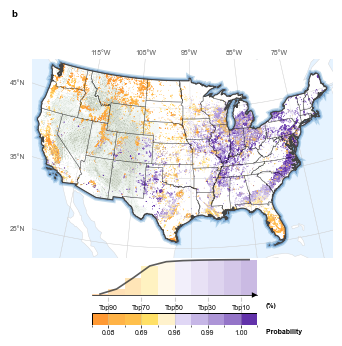

C:\Users\zpy10\AppData\Local\Temp\ipykernel_19832\716257876.py:34: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  qm = ax.pcolormesh(gx, gy, elev, cmap=terrain_colors, norm=norm,


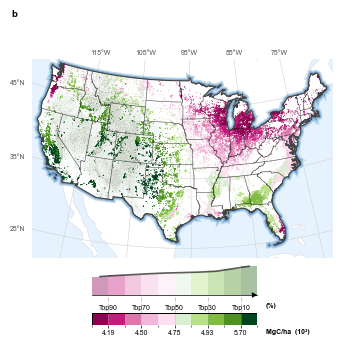

C:\Users\zpy10\AppData\Local\Temp\ipykernel_19832\716257876.py:34: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  qm = ax.pcolormesh(gx, gy, elev, cmap=terrain_colors, norm=norm,


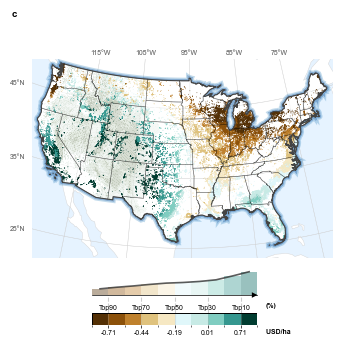

所有图片生成完成！


In [66]:

# ==================== 主程序 ====================
# 定义三个变量的参数
variables_config = [
    {
        'name': 'predicted_prob',
        'title': 'Environmental Potential',
        'unit': 'Probability',
        'colors': [
            '#ff9933','#ffb347' ,'#ffc04c', '#ffe066',  '#fff2cc',
            '#e0d7f5','#c6b6e6','#ad95d7','#9474c8','#7b53b9','#6232aa'
        ],
        'filename': 'environmental score'
    },
    {
        'name': 'Expectation_net_benefit', 
        'title': 'Carbon Mitigation Potential',
        'unit': 'MgC/ha ',
        'colors': [
            '#8e0152', '#c51b7d', '#de77ae', '#f1b6da', '#fde0ef',
            '#d9f0d3', '#b8e186', '#7fbc41', '#4d9221', '#276419', '#00441b'
        ],
        'filename': 'carbon_mitigation_potential'
    },
    {
        'name': 'avg_npv',
        'title': 'Economic Potential', 
        'unit': 'USD/ha',
        'colors': [
            '#543005', '#8c510a', '#bf812d', '#dfc27d', '#f6e8c3',
            '#e0f7fa', '#c7eae5', '#80cdc1', '#35978f', '#01665e', '#003c30'
        ],
        'filename': 'economic_potential'
    }
]

# 生成三个单独的图
panel_labels = ['b', 'b', 'c']

for i, var_config in enumerate(variables_config):
    try:
        add_north_arrow_and_scalebar = (i == 0)
        add_embedding_points = False

        fig, ax = plot_single_variable(
            merged_data_for_plot, 
            us_states_4326, 
            dem_us,
            var_config['name'],
            var_config['title'],
            var_config['unit'],
            var_config['colors'],
            add_north_arrow_and_scalebar=add_north_arrow_and_scalebar,
            add_embedding_points=add_embedding_points
        )

        fig.text(0.01, 0.99, panel_labels[i], ha='left', va='top', fontsize=7, fontweight='bold',
         bbox=dict(facecolor='white', alpha=0.7, pad=0.2, lw=0), zorder=100)

        # 保存图片
        filename_png = f"figure/US_figure/{var_config['filename']}_nature_style_300dpi.png"
        filename_pdf = f"figure/US_figure/{var_config['filename']}_nature_style_300dpi.pdf"
        
        fig.savefig(filename_png, dpi=300, facecolor='White')  
        fig.canvas.draw()
        fig.savefig(filename_pdf, dpi=300, facecolor='None')                       

        plt.show()
        plt.close(fig)

    except Exception as e:
        print(e)
        continue

print("所有图片生成完成！")

# 2、环境蜂窝图

现在需要绘制一个全美环境结构变量的蜂窝图，要求不同的蜂窝能够根据GMM打分体现不同的环境结构。

计算模块：
主要分为GMM评分与层次聚类计算模块、US蜂窝聚类生成模块、蜂窝图例映射模块

```模块一：US蜂窝聚类生成模块

数据接口：用xarray打开ds_all，其中的feature_groups所涉及变量是各个variable名称；蜂窝面积2500平方公里
计算执行：以各个蜂窝为单位，用Mean聚合各个variable
数据输出：feature_groups在各个蜂窝以Mean聚合生成的dataframe或者json，记为hex_groups_mean

```


```模块二：GMM评分与层次聚类模块

数据接口：导入gmm_model_34c_fixed.pkl模型，模块一生成的蜂窝数据结构
计算执行：第一，参照plot_abandon_component_probabilities的逻辑，根据输入的hex_groups_mean计算各个蜂窝的component概率$P(z_{k}|x_{i})$，并且根据Comonet to cluster maps聚合成Cluster的概率；第二，同时参照plot_gmm_component_patterns函数中feature_groups的模式条的计算方法，计算蜂窝内的样式条的比例
数据输出：各个蜂窝属于各个Cluster的概率、各个蜂窝的样式条比例

```


```模块三：蜂窝图例映射模块

数据接口：各个蜂窝属于各个Cluster的概率
计算执行：一共有4个Cluster，按照概率大小映射自定义的图例，在各个蜂窝内部填充对应的图例。
这个图例的内容主要包括两块设计组分
第一，圆心Cluster部分
在每个蜂窝的中心生成一个半径r的圆（r的大小约为蜂窝边长的1/3）
中间的圆心颜色代表了属于哪个Cluster的概率最大
第二，周围圆的pattern部分
记录圆心+半径r位置，在2r处生成圆形
各个圆形代表了各个feature_groups的贡献
数据输出：各个蜂窝所对应的图例

```



特征输入：
    feature_groups = {
        'Socioeconomic': ['Population', 'GDPpc', 'GDPtot', 'GURdist'],
        'Infrastructure': ['Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad'],
        'Geographic': ['DEM', 'Slope', 'gdmp'],
        'Climatic': ['rsds', 'tas', 'wind'],
    }
    time ==2020-01-01

Comonet to cluster map：
  Cluster 4: Components [0, 6, 15, 20, 30]
  Cluster 2: Components [1, 3, 5, 7, 11, 12, 14, 16, 25, 28, 31, 32]
  Cluster 1: Components [2, 4, 8, 10, 18, 21, 22, 23, 27, 33]
  Cluster 3: Components [9, 13, 17, 19, 24, 26, 29]

GMM模型输入：
gmm_model_34c_fixed.pkl

包导入：
from function import *
C:\Dev\Landuse_Zhong_clean\function\gmm_training.py

## Load data

In [2]:
from function import *
from function.load_all_ds import load_all_ds
from function.gmm_training import CombinedPreprocessor  
import h3
import geopandas as gpd
import joblib
from shapely.geometry import Polygon, Point, box
from pyproj import Transformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load datasets
ds_all = load_all_ds()
gmm_pipeline = joblib.load('gmm_model_34c_fixed.pkl')

# Load US shapefiles
us_nation = gpd.read_file(r'data\US_data\cb_2018_us_nation_5m.shp')
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')

print(f"ds_all shape: {ds_all.dims if hasattr(ds_all, 'dims') else 'N/A'}")
print(f"GMM model loaded: {gmm_pipeline}")

gogogo
✅ TensorFlow available
✅ scikeras available
✅ SHAP available


c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 174
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 14
  result = blockwise(
c:\Users\zpy10\anacon

ds_all shape: FrozenMappingWarningOnValuesAccess({'time': 31, 'lat': 21600, 'lon': 43200})
GMM model loaded: Pipeline(steps=[('preprocessor',
                 CombinedPreprocessor(categorical_features=['landcover'],
                                      numeric_features=['GDPpc', 'GDPtot',
                                                        'Population',
                                                        'Powerdist', 'DEM',
                                                        'Slope', 'GURdist',
                                                        'PrimaryRoad',
                                                        'SecondaryRoad',
                                                        'TertiaryRoad', 'tas',
                                                        'gdmp', 'rsds',
                                                        'wind'])),
                ('gmm',
                 GaussianMixture(covariance_type='diag', n_components=34,
                           

## Module 1: H3 Hexagonal Grid Generation and Data Aggregation


In [60]:
from tqdm.auto import tqdm

# Define feature groups
feature_groups = {
    'Socioeconomic': ['Population', 'GDPpc', 'GDPtot', 'GURdist'],
    'Infrastructure': ['Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad'],
    'Geographic': ['DEM', 'Slope', 'gdmp'],
    'Climatic': ['rsds', 'tas', 'wind'],
}

# Get all variable names
all_vars = []
for group, vars_list in feature_groups.items():
    all_vars.extend(vars_list)


all_vars.append('landcover')
print(f"\nAll variables with landcover ({len(all_vars)}): {all_vars}")
print("Feature groups defined:")
for group, vars_list in feature_groups.items():
    print(f"  {group}: {vars_list}")
print(f"\nAll variables ({len(all_vars)}): {all_vars}")

# Check what's available in ds_all
print(f"\nds_all available variables: {list(ds_all.data_vars) if hasattr(ds_all, 'data_vars') else 'N/A'}")

def create_h3_hexagons_optimized(us_boundary, ds_all, time='2020-01-01', resolution=7,
                                 max_workers=8, parallel=True):
    """
    优化版：仅对美国本土(最大Polygon)做 H3 覆盖；对落入研究区的所有栅格点一次性取样并按 hex 聚合

    Parameters
    ----------
    us_boundary : GeoDataFrame 或 shapely (Multi)Polygon (EPSG:4326)
    ds_all      : xarray.Dataset，包含 all_vars 提到的变量
    time        : str，时间切片
    resolution  : int，H3 分辨率（7~8 常用）
    max_workers : int，并行线程数（用于大数据时的 H3 映射/几何）
    parallel    : bool，是否并行

    Returns
    -------
    GeoDataFrame[hex_id, variables..., geometry, center*, ...]  (EPSG:4326)
    """
    import numpy as np
    import pandas as pd
    import geopandas as gpd
    from shapely.geometry import Polygon, MultiPolygon, Point
    from shapely.ops import transform as shp_transform
    from concurrent.futures import ThreadPoolExecutor

    # ---------- H3 兼容导入 ----------
    try:
        import h3  # 可能是 v4
        _H3_V4 = hasattr(h3, "polyfill_geojson") or hasattr(h3, "polygon_to_cells") or hasattr(h3, "latlng_to_cell")
    except ImportError:
        h3 = None
        _H3_V4 = False

    try:
        from h3 import h3 as h3_legacy  # v3 旧接口
        _H3_V3 = True
    except ImportError:
        h3_legacy = None
        _H3_V3 = False

    if not (_H3_V4 or _H3_V3):
        raise ImportError("No usable H3 found. Install with `pip install h3`.")

    def _rings_of_polygon(poly: Polygon):
        # GeoJSON 需要 (lon, lat)
        ext = [(x, y) for x, y in poly.exterior.coords]
        holes = [[(x, y) for x, y in r.coords] for r in poly.interiors]
        return [ext] + holes

    def _geojson_coords(geom):
        if geom.geom_type == "Polygon":
            return _rings_of_polygon(geom)  # [ext, hole1, ...]
        elif geom.geom_type == "MultiPolygon":
            return [_rings_of_polygon(p) for p in geom.geoms]  # [[ext,...], [ext,...], ...]
        else:
            raise TypeError(f"Unsupported geometry type: {geom.geom_type}")

    # H3 封装：点 -> cell
    def H3_latlng_to_cell(lat, lon, res):
        if _H3_V4 and hasattr(h3, "latlng_to_cell"):
            return h3.latlng_to_cell(lat, lon, res)
        if _H3_V3 and hasattr(h3_legacy, "geo_to_h3"):
            return h3_legacy.geo_to_h3(lat, lon, res)
        raise RuntimeError("No latlng_to_cell / geo_to_h3 available in your H3.")

    # H3 封装：Polygon/MultiPolygon -> cells
    from shapely.geometry import mapping

    def H3_cover_from_geom(geom, res):
        """
        生成六边形覆盖，兼容 H3 v4 与 v3。
        - v4: 接受 GeoJSON dict（(lon,lat)）
        - v3: 接受环坐标列表（(lat,lon)），不接受 dict
        """
        # ---- v4 优先：polyfill_geojson / polygon_to_cells ----
        if _H3_V4:
            gj = mapping(geom)  # 标准 GeoJSON dict，坐标为 (lon,lat)
            # 有些 v4 只有其中一个函数，按可用性调用
            if hasattr(h3, "polyfill_geojson"):
                return set(h3.polyfill_geojson(gj, res))
            if hasattr(h3, "polygon_to_cells"):
                return set(h3.polygon_to_cells(gj, res))
            # 继续尝试 v3
            # (不要 raise，这里让它走到 v3 分支)
        
        # ---- v3：polyfill 需要 (lat,lon) 的环列表，不吃 dict ----
        if _H3_V3 and hasattr(h3_legacy, "polyfill"):
            def _rings_latlon(poly):
                # exterior + holes，且顺序转换为 (lat,lon)
                ext = [(y, x) for (x, y) in poly.exterior.coords]
                holes = [[(y, x) for (x, y) in r.coords] for r in poly.interiors]
                return [ext] + holes

            cells = set()
            if geom.geom_type == "Polygon":
                rings = _rings_latlon(geom)
                cells |= set(h3_legacy.polyfill(rings, res, geo_json_conformant=False))
            elif geom.geom_type == "MultiPolygon":
                for p in geom.geoms:
                    rings = _rings_latlon(p)
                    cells |= set(h3_legacy.polyfill(rings, res, geo_json_conformant=False))
            else:
                raise TypeError(f"Unsupported geometry type: {geom.geom_type}")
            return cells

        raise RuntimeError("No usable H3 cover function available (neither v4 polyfill_geojson/polygon_to_cells nor v3 polyfill).")


    # H3 封装：cell 边界 / 中心（统一输出 (lon,lat)，不传 geo_json=）
    def H3_cell_boundary_lonlat(cell):
        if _H3_V4 and hasattr(h3, "cell_to_boundary"):
            coords = h3.cell_to_boundary(cell)  # 多数版本返 (lat, lon)
        elif _H3_V3 and hasattr(h3_legacy, "h3_to_geo_boundary"):
            coords = h3_legacy.h3_to_geo_boundary(cell)
        else:
            raise RuntimeError("No cell_to_boundary / h3_to_geo_boundary found.")
        return [(lon, lat) for (lat, lon) in coords]

    def H3_cell_center_lonlat(cell):
        if _H3_V4 and hasattr(h3, "cell_to_latlng"):
            lat, lon = h3.cell_to_latlng(cell)
        elif _H3_V3 and hasattr(h3_legacy, "h3_to_geo"):
            lat, lon = h3_legacy.h3_to_geo(cell)
        else:
            raise RuntimeError("No cell_to_latlng / h3_to_geo found.")
        return (lon, lat)

    from pyproj import Transformer
    from shapely.geometry import shape

    print(f"\n=== 优化版：H3覆盖法生成六边形 (分辨率 {resolution}) ===")
    print("Step 1: 生成US区域的H3六边形覆盖...")

    # 统一获取几何
    us_geom = us_boundary.geometry.iloc[0] if isinstance(us_boundary, gpd.GeoDataFrame) else us_boundary

    # 修复几何（防自交）
    try:
        from shapely.validation import make_valid
        us_geom = make_valid(us_geom)
    except Exception:
        us_geom = us_geom.buffer(0)

    # 只取最大 Polygon（在等面积投影下择优）
    if us_geom.geom_type == "MultiPolygon":
        print("  检测到 MultiPolygon，选择面积最大的多边形（本土美国）...")
        fwd = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True).transform
        areas = [shp_transform(fwd, p).area for p in us_geom.geoms]
        us_geom = list(us_geom.geoms)[int(np.argmax(areas))]
    elif us_geom.geom_type != "Polygon":
        raise ValueError(f"不支持的地理类型: {us_geom.geom_type}")

    print(f"  使用 Polygon，外环顶点数: {len(us_geom.exterior.coords)}")

    # 覆盖（严格 API 兼容）
    try:
        cells_list = list(H3_cover_from_geom(us_geom, resolution))
    except Exception as e:
        # 最后兜底：bbox 网格采样覆盖（尽量少用）
        print(f"  规范覆盖失败：{e}")
        print("  使用降级方案：bbox 采样覆盖 ...")
        minx, miny, maxx, maxy = us_geom.bounds
        step_deg = 0.25
        lon_samples = np.arange(minx, maxx, step_deg)
        lat_samples = np.arange(miny, maxy, step_deg)
        # contains_xy (Shapely 2) / vectorized.contains (<=1.8) 兼容
        try:
            from shapely import contains_xy
            def _inside(lon, lat): return contains_xy(us_geom, lon, lat)
        except Exception:
            from shapely.vectorized import contains as vcontains
            def _inside(lon, lat): return vcontains(us_geom, lon, lat)
        cells = set()
        for lat in lat_samples:
            for lon in lon_samples:
                if _inside(lon, lat):
                    try:
                        cells.add(H3_latlng_to_cell(lat, lon, resolution))
                    except Exception:
                        pass
        cells_list = list(cells)

    print(f"  生成了 {len(cells_list):,} 个六边形单元")

    # ---------- Step 2: 向量化统计（在研究区内的所有栅格点 -> hex -> groupby mean） ----------
    print("\nStep 2: 对研究区栅格点向量化取样，并按 hex 聚合...")

    # 选择时间切片
    ds_slice = ds_all.sel(time=time) if "time" in ds_all.coords else ds_all

    # 提取经纬度坐标
    if hasattr(ds_slice, 'lon') and hasattr(ds_slice, 'lat'):
        lons = np.asarray(ds_slice.lon.values)
        lats = np.asarray(ds_slice.lat.values)
    elif hasattr(ds_slice, 'longitude') and hasattr(ds_slice, 'latitude'):
        lons = np.asarray(ds_slice.longitude.values)
        lats = np.asarray(ds_slice.latitude.values)
    else:
        raise ValueError("Cannot find lon/lat coords in ds_all")

    # 只在美国本土 bbox 内构网格，再精筛到面内
    minx, miny, maxx, maxy = us_geom.bounds
    if lons.ndim == 1 and lats.ndim == 1 and (np.all(np.diff(lons)>=0) and np.all(np.diff(lats)>=0)):
        i0 = max(0, np.searchsorted(lons, minx, side='left'))
        i1 = min(len(lons), np.searchsorted(lons, maxx, side='right'))
        j0 = max(0, np.searchsorted(lats, miny, side='left'))
        j1 = min(len(lats), np.searchsorted(lats, maxy, side='right'))
        sub_lons = lons[i0:i1]
        sub_lats = lats[j0:j1]
        xx, yy = np.meshgrid(sub_lons, sub_lats, indexing='xy')
    else:
        xx, yy = np.meshgrid(lons, lats, indexing='xy') if lons.ndim==1 else (lons, lats)

    # contains_xy / vectorized.contains 兼容
    try:
        from shapely import contains_xy
        mask = contains_xy(us_geom, xx, yy)
    except Exception:
        from shapely.vectorized import contains as vcontains
        mask = vcontains(us_geom, xx, yy)

    xs = xx[mask].ravel()
    ys = yy[mask].ravel()
    print(f"  面内栅格点: {xs.size:,}")

    # 一次性插值所有变量（nearest）
    sampled = ds_slice[all_vars].interp(
        lon=('points', xs), lat=('points', ys), method='nearest'
    ).to_array('variable')  # (variable, points)

    data_matrix = sampled.transpose('points', 'variable').values  # ndarray
    var_names = sampled['variable'].values

    # 点 -> hex（可并行）
    def _map_chunk(idx):
        return [H3_latlng_to_cell(ys[i], xs[i], resolution) for i in idx]

    if parallel and xs.size > 50_000:
        chunks = np.array_split(np.arange(xs.size), max_workers)
        with ThreadPoolExecutor(max_workers=max_workers) as ex:
            parts = list(ex.map(_map_chunk, chunks))
        hex_ids = np.fromiter((h for p in parts for h in p), dtype=object, count=xs.size)
    else:
        hex_ids = np.fromiter((H3_latlng_to_cell(lat, lon, resolution) for lon, lat in zip(xs, ys)),
                              dtype=object, count=xs.size)

    # 只保留在覆盖集中的 hex
    cover_set = set(cells_list)
    keep = np.fromiter((h in cover_set for h in hex_ids), dtype=bool, count=hex_ids.size)
    hex_ids = hex_ids[keep]
    data_matrix = data_matrix[keep, :]

    # 在聚合部分（第279-294行）替换为：

    numeric_vars = [v for v in var_names if v != 'landcover']
    categorical_vars = ['landcover'] if 'landcover' in var_names else []

    # 自定义聚合函数
    def q75_no_zero(x):
        """计算非零值的75%分位数"""
        clean_x = x[x > 0]
        if len(clean_x) == 0:
            return 0
        return np.percentile(clean_x, 75)

    agg_dict = {var: 'mean' for var in numeric_vars}

    # Powerdist和GURdist使用75%分位数（去除0值）
    if 'Powerdist' in numeric_vars:
        agg_dict['Powerdist'] = q75_no_zero
    if 'GURdist' in numeric_vars:
        agg_dict['GURdist'] = q75_no_zero

    if categorical_vars:
        agg_dict.update({var: lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0] 
                    for var in categorical_vars})

    # 聚合
    df_points = pd.DataFrame(data_matrix, columns=var_names)
    df_points['hex_id'] = hex_ids

    # 统计0值
    print("\n  原始栅格点的0值统计:")
    for var in ['Powerdist', 'GURdist']:
        if var in df_points.columns:
            zero_count = (df_points[var] == 0).sum()
            total = len(df_points)
            print(f"    {var}: {zero_count:,}/{total:,} ({zero_count/total*100:.1f}%) 个点=0")

    print("\n  过滤掉Powerdist和GURdist为0的点...")
    initial_count = len(df_points)

    # 过滤Powerdist=0的点
    df_points = df_points[df_points['Powerdist'] > 1000]

    # 过滤GURdist=0的点  
    df_points = df_points[df_points['GURdist'] > 1000]

    removed_count = initial_count - len(df_points)
    print(f"    移除 {removed_count:,} 个点（Powerdist或GURdist=0）")
    print(f"    保留 {len(df_points):,} 个点用于聚合")

    df_hex = df_points.groupby('hex_id', sort=False, observed=True).agg(agg_dict).reset_index()
    # 统计聚合后的结果
    print("\n  聚合后六边形的0值统计:")
    for var in ['Powerdist', 'GURdist']:
        if var in df_hex.columns:
            zero_count = (df_hex[var] == 0).sum()
            total = len(df_hex)
            non_zero = df_hex[var][df_hex[var] > 0]
            print(f"    {var}: {zero_count}/{total} ({zero_count/total*100:.1f}%) 个六边形=0")
            if len(non_zero) > 0:
                print(f"      非零值: min={non_zero.min():.1f}, max={non_zero.max():.1f}, mean={non_zero.mean():.1f}")

    print(f"\n  聚合得到 hex 数量: {len(df_hex):,}")

    # ---------- Step 3: 构造几何（可并行） ----------
    print("\nStep 3: 构造六边形几何与中心点 ...")

    def _geom_center(hid):
        ring = H3_cell_boundary_lonlat(hid)  # (lon,lat)
        poly = Polygon(ring)
        cx, cy = H3_cell_center_lonlat(hid)  # (lon,lat)
        return poly, Point(cx, cy), cy, cx

    ids = df_hex['hex_id'].tolist()
    if parallel and len(ids) > 3_000:
        with ThreadPoolExecutor(max_workers=max_workers) as ex:
            results = list(ex.map(_geom_center, ids))
    else:
        results = [_geom_center(h) for h in ids]

    geoms, centers, center_lats, center_lons = zip(*results)

    # 组装 GeoDataFrame
    out = df_hex.copy()
    out['geometry']   = list(geoms)
    out['center']     = list(centers)
    out['center_lat'] = center_lats
    out['center_lon'] = center_lons

    hex_gdf = gpd.GeoDataFrame(out, geometry='geometry', crs='EPSG:4326')
    if 'landcover' in hex_gdf.columns:
        hex_gdf['landcover'] = hex_gdf['landcover'].astype(int)

    

    print(f"\n✅ 成功创建 GeoDataFrame: {len(hex_gdf):,} 个六边形")
    print(f"   空间范围: {hex_gdf.total_bounds}")
    print(f"\n数据预览:\n{hex_gdf.head()}")

    return hex_gdf


# 创建六边形覆盖（使用优化方法）
hex_gdf = create_h3_hexagons_optimized(us_nation, ds_all, time='2020-01-01', resolution=8)



All variables with landcover (15): ['Population', 'GDPpc', 'GDPtot', 'GURdist', 'Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad', 'DEM', 'Slope', 'gdmp', 'rsds', 'tas', 'wind', 'landcover']
Feature groups defined:
  Socioeconomic: ['Population', 'GDPpc', 'GDPtot', 'GURdist']
  Infrastructure: ['Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad']
  Geographic: ['DEM', 'Slope', 'gdmp']
  Climatic: ['rsds', 'tas', 'wind']

All variables (15): ['Population', 'GDPpc', 'GDPtot', 'GURdist', 'Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad', 'DEM', 'Slope', 'gdmp', 'rsds', 'tas', 'wind', 'landcover']

ds_all available variables: ['abandonment_year', 'abandonment_duration', 'recultivation', 'current_abandonment', 'landcover', 'DEM', 'gdmp', 'GDPpc', 'GDPtot', 'GURdist', 'landcover_at_abandonment', 'Population', 'Powerdist', 'PrimaryRoad', 'rsds', 'SecondaryRoad', 'Slope', 'tas', 'TertiaryRoad', 'wind']

=== 优化版：H3覆盖法生成六边形 (分辨率 8) ===
Step 1: 生成US区域的H3六边形覆盖...
  检测到

### Data check

In [55]:
def clip_data_with_us_states(df, us_states_gdf, lon_col='lon', lat_col='lat'):
    """
    使用美国州界 shapefile 剪裁点数据；兼容不同版本的 geopandas 参数名
    """
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    us_states_4326 = us_states_gdf.to_crs('EPSG:4326')

    try:
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', predicate='within')
    except TypeError:
        # 旧版本 geopandas 使用 op 参数
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', op='within')

    # 清理 shapefile 附加字段
    clipped = clipped.drop(columns=['geometry', 'index_right'], errors='ignore')
    for col in us_states_gdf.columns:
        if col in clipped.columns:
            clipped = clipped.drop(columns=[col], errors='ignore')
    return clipped

usa_bounds_main = dict(lon_min=-125, lon_max=-65, lat_min=25, lat_max=49)


df_abandon = load_abandon(PATHS['us_abandon'])
df_embedding = load_embedding(PATHS['us_pv_embedding'])
df_net_benefit = pd.read_csv('data/US_data/df_net_benefit.csv')

# 初步经纬度范围过滤
df_embedding = df_embedding[
    (df_embedding['lon'] >= usa_bounds_main['lon_min']) &
    (df_embedding['lon'] <= usa_bounds_main['lon_max']) &
    (df_embedding['lat'] >= usa_bounds_main['lat_min']) &
    (df_embedding['lat'] <= usa_bounds_main['lat_max'])
]

# 第二次用州界矢量更精确裁剪
df_abandon = clip_data_with_us_states(df_abandon, us_states)
df_embedding = clip_data_with_us_states(df_embedding, us_states)

# ---------------------------
# 2) 缺失值填充 + 去重
# ---------------------------
df_abandon_fill   = fill_nonpositive_with_nearest(df_abandon)
df_embedding_fill = fill_nonpositive_with_nearest(df_embedding)

df_abandon_filtered = filter_duplicates(df_abandon_fill, df_embedding_fill)
df_abandon_filtered=df_abandon_filtered.merge(df_net_benefit[['lon', 'lat', 'area_m2']], on=['lat', 'lon'], how='left')
features_no_coords = [f for f in (NUMERIC_FEATURES + CAT_COLS) if f not in ['lat', 'lon']]
features_no_coords = [c for c in features_no_coords if c in df_embedding_fill.columns]

You want to predict the year: 2020.0
列 GDPpc 没有需要填充的非正值或NaN值
列 GURdist 没有需要填充的非正值或NaN值
列 GDPpc 没有需要填充的非正值或NaN值
列 GURdist 没有需要填充的非正值或NaN值


In [66]:
df_abandon_fill['Powerdist'].min()

622545.0

In [61]:
def comprehensive_three_way_comparison(df_embedding, df_abandon, hex_gdf, gmm_pipeline):
    """
    综合对比df_embedding（训练用正样本）、df_abandon（撂荒地样本）、hex_gdf（六边形聚合数据）
    诊断为什么hex_gdf全部归到Component 27
    """
    import pandas as pd
    import numpy as np
    from scipy.stats import ks_2samp
    from collections import Counter
    
    preprocessor = gmm_pipeline.named_steps['preprocessor']
    gmm = gmm_pipeline.named_steps['gmm']
    
    numeric_features = preprocessor.numeric_features
    categorical_features = preprocessor.categorical_features
    all_features = numeric_features + categorical_features
    
    print("="*90)
    print("                     三数据集综合对比诊断报告")
    print("="*90)
    
    # ===== 1. 数据集基础信息 =====
    print(f"\n【1】数据集规模")
    print(f"{'数据集':<15} {'样本数':<12} {'空间覆盖':<40} {'说明'}")
    print("-"*90)
    print(f"{'df_embedding':<15} {len(df_embedding):<12} {'US全域点数据':<40} {'训练用正样本'}")
    print(f"{'df_abandon':<15} {len(df_abandon):<12} {'US全域点数据':<40} {'测试用撂荒地'}")
    print(f"{'hex_gdf':<15} {len(hex_gdf):<12} {'US全域六边形覆盖':<40} {'聚合数据'}")
    
    # ===== 2. 关键特征统计对比 =====
    print(f"\n【2】关键特征统计对比（Powerdist & GURdist）")
    print(f"{'特征':<12} {'数据集':<12} {'均值':<12} {'标准差':<12} {'最小值':<12} {'最大值':<12}")
    print("-"*80)
    
    key_features = ['Powerdist', 'GURdist', 'GDPpc', 'Population']
    for feat in key_features:
        if feat in numeric_features:
            print(f"\n{feat}:")
            
            # df_embedding统计
            if feat in df_embedding.columns:
                embed_mean = df_embedding[feat].mean()
                embed_std = df_embedding[feat].std()
                embed_min = df_embedding[feat].min()
                embed_max = df_embedding[feat].max()
                print(f"  {'df_embedding':<12} {embed_mean:<12.2f} {embed_std:<12.2f} {embed_min:<12.2f} {embed_max:<12.2f}")
            
            # df_abandon统计
            if feat in df_abandon.columns:
                abandon_mean = df_abandon[feat].mean()
                abandon_std = df_abandon[feat].std()
                abandon_min = df_abandon[feat].min()
                abandon_max = df_abandon[feat].max()
                print(f"  {'df_abandon':<12} {abandon_mean:<12.2f} {abandon_std:<12.2f} {abandon_min:<12.2f} {abandon_max:<12.2f}")
            
            # hex_gdf统计
            if feat in hex_gdf.columns:
                hex_mean = hex_gdf[feat].mean()
                hex_std = hex_gdf[feat].std()
                hex_min = hex_gdf[feat].min()
                hex_max = hex_gdf[feat].max()
                print(f"  {'hex_gdf':<12} {hex_mean:<12.2f} {hex_std:<12.2f} {hex_min:<12.2f} {hex_max:<12.2f}")
    
    # ===== 3. 标准化后的特征分布 =====
    print(f"\n【3】标准化后的特征分布")
    
    # 转换数据
    embed_transformed = preprocessor.transform(df_embedding[all_features])
    abandon_transformed = preprocessor.transform(df_abandon[all_features])
    hex_transformed = preprocessor.transform(hex_gdf[all_features])
    
    feature_names = preprocessor.get_feature_names_out()
    
    print(f"{'特征':<12} {'df_embedding均值':<20} {'df_abandon均值':<20} {'hex_gdf均值':<20}")
    print("-"*80)
    
    for i, feat in enumerate(numeric_features[:8]):  # 只显示前8个
        if i < len(feature_names):
            embed_mean = embed_transformed[:, i].mean()
            abandon_mean = abandon_transformed[:, i].mean()
            hex_mean = hex_transformed[:, i].mean()
            
            print(f"{feat:<12} {embed_mean:>10.3f}±{embed_transformed[:, i].std():>6.3f}  "
                  f"{abandon_mean:>10.3f}±{abandon_transformed[:, i].std():>6.3f}  "
                  f"{hex_mean:>10.3f}±{hex_transformed[:, i].std():>6.3f}")
    
    # 关键：Powerdist和GURdist的位置
    if 'Powerdist' in numeric_features:
        idx = numeric_features.index('Powerdist')
        print(f"\n⚠️ Powerdist标准化后:")
        print(f"  df_embedding: {embed_transformed[:, idx].mean():.3f}")
        print(f"  df_abandon:   {abandon_transformed[:, idx].mean():.3f}")
        print(f"  hex_gdf:      {hex_transformed[:, idx].mean():.3f}")
        print(f"  → hex_gdf偏离: {abs(hex_transformed[:, idx].mean() - embed_transformed[:, idx].mean()):.2f} 标准差")
    
    # ===== 4. GMM Component分布对比 =====
    print(f"\n【4】GMM Component概率分布")
    
    # 计算各组件的概率
    embed_probs = gmm.predict_proba(embed_transformed)
    abandon_probs = gmm.predict_proba(abandon_transformed)
    hex_probs = gmm.predict_proba(hex_transformed)
    
    # 找到dominant component
    embed_dominant = np.argmax(embed_probs, axis=1)
    abandon_dominant = np.argmax(abandon_probs, axis=1)
    hex_dominant = np.argmax(hex_probs, axis=1)
    
    # 统计
    embed_counts = Counter(embed_dominant)
    abandon_counts = Counter(abandon_dominant)
    hex_counts = Counter(hex_dominant)
    
    print(f"  Unique components:")
    print(f"    df_embedding: {len(embed_counts)} 个")
    print(f"    df_abandon:   {len(abandon_counts)} 个")
    print(f"    hex_gdf:      {len(hex_counts)} 个")
    
    # 显示各数据集的主要components
    print(f"\n  各数据集Dominant Component分布（Top 10）:")
    print(f"  {'Component':<12} {'df_embedding':<15} {'df_abandon':<15} {'hex_gdf':<15}")
    print("-"*80)
    
    all_components = set(embed_counts.keys()) | set(abandon_counts.keys()) | set(hex_counts.keys())
    top_components = sorted(all_components, 
                           key=lambda c: embed_counts.get(c,0) + abandon_counts.get(c,0) + hex_counts.get(c,0),
                           reverse=True)[:10]
    
    for comp in top_components:
        embed_count = embed_counts.get(comp, 0)
        abandon_count = abandon_counts.get(comp, 0)
        hex_count = hex_counts.get(comp, 0)
        
        embed_pct = embed_count / len(df_embedding) * 100 if len(df_embedding) > 0 else 0
        abandon_pct = abandon_count / len(df_abandon) * 100 if len(df_abandon) > 0 else 0
        hex_pct = hex_count / len(hex_gdf) * 100 if len(hex_gdf) > 0 else 0
        
        print(f"  {comp:<12} {embed_count:<7} ({embed_pct:>5.1f}%)  {abandon_count:<7} ({abandon_pct:>5.1f}%)  {hex_count:<7} ({hex_pct:>5.1f}%)")
    
    # ===== 5. 关键诊断 =====
    print(f"\n【5】关键诊断")
    
    # 检查hex_gdf是否全部归到一个component
    if len(hex_counts) == 1:
        comp_id = hex_counts.most_common(1)[0][0]
        print(f"  ❌ 问题确认：hex_gdf 100%归到Component {comp_id}")
        
        # 检查该component在其他数据集的表现
        embed_pct = embed_counts.get(comp_id, 0) / len(df_embedding) * 100 if len(df_embedding) > 0 else 0
        abandon_pct = abandon_counts.get(comp_id, 0) / len(df_abandon) * 100 if len(df_abandon) > 0 else 0
        
        print(f"     该Component在df_embedding中占比: {embed_pct:.1f}%")
        print(f"     该Component在df_abandon中占比: {abandon_pct:.1f}%")
        
        # 分析原因
        if 'Powerdist' in numeric_features:
            powerdist_idx = numeric_features.index('Powerdist')
            hex_powerdist_mean = hex_transformed[:, powerdist_idx].mean()
            embed_powerdist_mean = embed_transformed[:, powerdist_idx].mean()
            diff = abs(hex_powerdist_mean - embed_powerdist_mean)
            
            print(f"\n  🔍 原因分析:")
            print(f"     Powerdist标准化值: hex_gdf={hex_powerdist_mean:.2f} vs df_embedding={embed_powerdist_mean:.2f}")
            print(f"     偏离: {diff:.2f} 标准差")
            
            if diff > 3:
                print(f"     ❌ 偏离过大（>3σ），足以导致分类错误")
    
    # ===== 6. 分布相似性检验 =====
    print(f"\n【6】特征分布相似性（KS检验）")
    print(f"{'特征':<12} {'embed vs abandon':<20} {'embed vs hex':<20}")
    print("-"*60)
    
    different_features = []
    for feat in numeric_features[:8]:
        if (feat in df_embedding.columns and feat in df_abandon.columns and 
            feat in hex_gdf.columns):
            
            # embed vs abandon
            embed_clean = df_embedding[feat].dropna().replace([np.inf, -np.inf], np.nan).dropna()
            abandon_clean = df_abandon[feat].dropna().replace([np.inf, -np.inf], np.nan).dropna()
            hex_clean = hex_gdf[feat].dropna().replace([np.inf, -np.inf], np.nan).dropna()
            
            if len(embed_clean) > 10 and len(abandon_clean) > 10 and len(hex_clean) > 10:
                stat_ea, p_ea = ks_2samp(embed_clean, abandon_clean)
                stat_eh, p_eh = ks_2samp(embed_clean, hex_clean)
                
                conclusion_ea = "❌不同" if p_ea < 0.05 else "✅相似"
                conclusion_eh = "❌不同" if p_eh < 0.05 else "✅相似"
                
                if p_eh < 0.05:
                    different_features.append(feat)
                
                print(f"{feat:<12} {conclusion_ea:<20} {conclusion_eh:<20}")
    
    # ===== 7. 最终建议 =====
    print(f"\n【7】诊断结论与建议")
    
    if len(hex_counts) == 1:
        print(f"  🎯 核心问题：hex_gdf全部归到一个Component")
        if different_features:
            print(f"     - 分布不匹配的特征: {', '.join(different_features[:3])}")
        
        print(f"\n  建议：")
        print(f"  1. 对Powerdist和GURdist做log1p变换")
        print(f"  2. 使用中位数而非均值聚合")
        print(f"  3. 提高H3分辨率（更小的六边形）")
        print(f"  4. 检查训练数据的预处理流程")
    
    print("="*90)
    
    return {
        'embed_dominant': embed_dominant,
        'abandon_dominant': abandon_dominant,
        'hex_dominant': hex_dominant,
        'embed_transformed': embed_transformed,
        'abandon_transformed': abandon_transformed,
        'hex_transformed': hex_transformed,
        'different_features': different_features
    }

# 使用方法
result = comprehensive_three_way_comparison(
    df_embedding_fill, 
    df_abandon_filtered, 
    hex_gdf, 
    gmm_pipeline
)

                     三数据集综合对比诊断报告

【1】数据集规模
数据集             样本数          空间覆盖                                     说明
------------------------------------------------------------------------------------------
df_embedding    10152        US全域点数据                                  训练用正样本
df_abandon      64982        US全域点数据                                  测试用撂荒地
hex_gdf         8655         US全域六边形覆盖                                聚合数据

【2】关键特征统计对比（Powerdist & GURdist）
特征           数据集          均值           标准差          最小值          最大值         
--------------------------------------------------------------------------------

Powerdist:
  df_embedding 622564.37    5.87         622545.50    622581.06   
  df_abandon   622564.61    7.14         622545.00    622581.06   
  hex_gdf      7476.70      8320.64      1104.20      67933.20    

GURdist:
  df_embedding 624747.65    238.00       624549.56    625079.20   
  df_abandon   625062.80    7.13         625043.20    625079.25   
  hex_gdf    

## Module 2: GMM Scoring and Cluster Assignment


In [43]:
import joblib
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist
import geopandas as gpd
from shapely.geometry import Point


# component_to_cluster = {
#     'Cluster 1': [2, 4, 8, 10, 18, 21, 22, 23, 27, 33],  # 10个组件
#     'Cluster 2': [1, 3, 5, 7, 11, 12, 14, 16, 25, 28, 31, 32],  # 12个组件
#     'Cluster 3': [9, 13, 17, 19, 24, 26, 29],  # 7个组件
#     'Cluster 4': [0, 6, 15, 20, 30]  # 5个组件
# }
def calculate_cluster_probabilities(hex_gdf, gmm_pipeline, distance_threshold=1.5):
    """
    Calculate cluster probabilities using dynamic hierarchical clustering.
    参考 abandon_component_prob_stats 的逻辑，增加详细统计和数据质量检查。
    """
    print("\n=== Calculating Cluster Probabilities ===")
    
    preprocessor = gmm_pipeline.named_steps['preprocessor']
    gmm = gmm_pipeline.named_steps['gmm']
    means = gmm.means_
    n_components = gmm.n_components
    
    # 动态层次聚类
    numeric_features = preprocessor.numeric_features
    categorical_features = preprocessor.categorical_features
    n_numeric = len(numeric_features)
    
    print(f"模型特征信息：")
    print(f"  Numeric features: {numeric_features}")
    print(f"  Categorical features: {categorical_features}")
    
    if categorical_features:
        landcover_means = means[:, n_numeric:]
        dominant_landcover_values = np.take_along_axis(
            landcover_means, 
            np.argmax(landcover_means, axis=1)[:, np.newaxis], 
            axis=1
        ).squeeze()
        component_features_std = np.column_stack([
            means[:, :n_numeric], 
            dominant_landcover_values[:, np.newaxis]
        ])
    else:
        component_features_std = means
    
    distance_matrix = pdist(component_features_std, metric='correlation')
    linkage_matrix = linkage(distance_matrix, method='ward')
    cluster_labels = fcluster(linkage_matrix, t=distance_threshold, criterion='distance')
    
    # 构建动态映射
    clusters_dict = {}
    for comp_idx in range(n_components):
        cluster_id = cluster_labels[comp_idx]
        if cluster_id not in clusters_dict:
            clusters_dict[cluster_id] = []
        clusters_dict[cluster_id].append(comp_idx)
    
    print(f"\n动态生成的聚类映射:")
    for cluster_id, components in clusters_dict.items():
        print(f"  Cluster {cluster_id}: Components {components}")
    
    # 关键：按照模型期望的features顺序排列列
    features_in_order = numeric_features + categorical_features
    
    # 数据质量检查
    print(f"\n=== 数据质量检查 ===")
    print(f"六边形数据统计（前5个特征）:")
    for feat in features_in_order[:5]:
        if feat in hex_gdf.columns:
            col_data = hex_gdf[feat]
            print(f"  {feat}: "
                  f"min={col_data.min():.2f}, "
                  f"max={col_data.max():.2f}, "
                  f"mean={col_data.mean():.2f}, "
                  f"NaN={col_data.isna().sum()}")
    
    # 检查缺失值
    data_for_transformation = hex_gdf[features_in_order]
    missing_counts = data_for_transformation.isnull().sum()
    if missing_counts.sum() > 0:
        print(f"\n⚠️ 发现缺失值:")
        for col in missing_counts[missing_counts > 0].index:
            print(f"  {col}: {missing_counts[col]} 缺失")
    
    # 检查无穷值
    inf_counts = np.isinf(data_for_transformation[numeric_features]).sum()
    if inf_counts.sum() > 0:
        print(f"\n⚠️ 发现无穷值:")
        for col in inf_counts[inf_counts > 0].index:
            print(f"  {col}: {inf_counts[col]} 无穷值")
    
    X_transformed = preprocessor.transform(hex_gdf[features_in_order])
    component_probs = gmm.predict_proba(X_transformed)
    
    print(f"\nComponent probabilities shape: {component_probs.shape}")
    
    # 详细统计各component的概率
    print("\n=== Component Probability Statistics ===")
    comp_means = component_probs.mean(axis=0)
    comp_max = component_probs.max(axis=0)
    comp_min = component_probs.min(axis=0)
    comp_dominant_counts = (np.argmax(component_probs, axis=1).reshape(-1,1) == np.arange(n_components)).sum(axis=0)
    
    # 显示前10个和后10个component的统计
    print("Top 10 components by average probability:")
    top_comps = np.argsort(comp_means)[-10:][::-1]
    for comp_idx in top_comps:
        if comp_means[comp_idx] > 0:
            print(f"Component {comp_idx}: mean={comp_means[comp_idx]:.4f}, "
                  f"max={comp_max[comp_idx]:.4f}, "
                  f"min={comp_min[comp_idx]:.4f}, "
                  f"dominant={comp_dominant_counts[comp_idx]}")
    
    n_hexagons = len(hex_gdf)
    
    # 聚合到cluster概率
    n_clusters = len(clusters_dict)
    cluster_probs = np.zeros((n_hexagons, n_clusters))
    
    for cluster_idx, components in enumerate(clusters_dict.values()):
        cluster_probs[:, cluster_idx] = component_probs[:, components].sum(axis=1)
    
    # Cluster概率统计
    print(f"\n=== Cluster Probability Statistics ===")
    print(f"Cluster probabilities shape: {cluster_probs.shape}")
    
    for cluster_idx in range(n_clusters):
        cluster_id = list(clusters_dict.keys())[cluster_idx]
        mean_prob = cluster_probs[:, cluster_idx].mean()
        max_prob = cluster_probs[:, cluster_idx].max()
        min_prob = cluster_probs[:, cluster_idx].min()
        print(f"Cluster {cluster_id}: mean={mean_prob:.3f}, max={max_prob:.3f}, min={min_prob:.3f}")
    
    # 统计dominant cluster分布
    dominant_clusters = cluster_probs.argmax(axis=1)
    for cluster_idx in range(n_clusters):
        cluster_id = list(clusters_dict.keys())[cluster_idx]
        count = (dominant_clusters == cluster_idx).sum()
        pct = 100 * count / n_hexagons
        print(f"Cluster {cluster_id}: {count} hexagons ({pct:.1f}%)")



    # 添加到calculate_cluster_probabilities函数中，在最后返回cluster_probs之前

    # ===== 新增：多维特征空间分析 =====
    print(f"\n=== 多维特征空间诊断 ===")

    # 1. 检查每个六边形到Component 27中心的距离
    X_transformed = preprocessor.transform(hex_gdf[features_in_order])
    comp27_mean = means[27]
    comp27_cov = gmm.covariances_[27]

    # 计算Mahalanobis距离
    from scipy.spatial.distance import cdist
    distances_to_comp27 = np.zeros(len(hex_gdf))
    for i in range(len(hex_gdf)):
        diff = X_transformed[i] - comp27_mean
        # 对于diag协方差
        inv_cov = 1.0 / (comp27_cov + 1e-8)
        distances_to_comp27[i] = np.sqrt(np.sum(diff**2 * inv_cov))

    print(f"到Component 27的距离统计:")
    print(f"  min: {distances_to_comp27.min():.3f}")
    print(f"  max: {distances_to_comp27.max():.3f}")
    print(f"  mean: {distances_to_comp27.mean():.3f}")
    print(f"  std: {distances_to_comp27.std():.3f}")

    # 2. 检查其他components的最近距离
    comp_probs_sample = gmm.predict_proba(X_transformed[:1000])  # 采样前1000个
    nearest_comps = np.argsort(comp_probs_sample, axis=1)[:, -5:]  # 每个样本的top5 components
    nearest_comp_counts = np.bincount(nearest_comps.flatten(), minlength=n_components)

    print(f"\n前1000个样本的最近5个components分布:")
    top_10_nearest = np.argsort(nearest_comp_counts)[-10:][::-1]
    for comp_idx in top_10_nearest:
        count = nearest_comp_counts[comp_idx]
        if count > 0:
            print(f"  Component {comp_idx}: {count}次出现在top5")

    # 3. 检查Component 27的中心特征
    print(f"\n=== Component 27 特征分析 ===")
    feature_names = preprocessor.get_feature_names_out()
    print("Component 27的中心特征值（前15个）:")
    for j in range(min(15, len(feature_names))):
        mean_val = comp27_mean[j]
        comp_std = np.sqrt(comp27_cov[j]) if comp27_cov.ndim == 1 else np.sqrt(np.diag(comp27_cov))[j]
        print(f"  {feature_names[j]}: {mean_val:.3f} ± {comp_std:.3f}")

    # 4. 检查几个典型六边形的特征值
    print(f"\n=== 典型六边形特征 vs Component 27 ===")
    for i in [0, 100, 500]:
        hex_features = X_transformed[i]
        print(f"\n六边形 #{i} (原始特征):")
        # 只显示数值特征
        for j, feat_name in enumerate(feature_names[:10]):
            hex_val = hex_features[j]
            comp_val = comp27_mean[j]
            diff = hex_val - comp_val
            print(f"  {feat_name}: hex={hex_val:7.3f}, comp27={comp_val:7.3f}, diff={diff:7.3f}")
    
    return cluster_probs



# Calculate cluster probabilities
cluster_probs = calculate_cluster_probabilities(hex_gdf, gmm_pipeline)


=== Calculating Cluster Probabilities ===
模型特征信息：
  Numeric features: ['GDPpc', 'GDPtot', 'Population', 'Powerdist', 'DEM', 'Slope', 'GURdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad', 'tas', 'gdmp', 'rsds', 'wind']
  Categorical features: ['landcover']

动态生成的聚类映射:
  Cluster 4: Components [0, 6, 15, 20, 30]
  Cluster 2: Components [1, 3, 5, 7, 11, 12, 14, 16, 25, 28, 31, 32]
  Cluster 1: Components [2, 4, 8, 10, 18, 21, 22, 23, 27, 33]
  Cluster 3: Components [9, 13, 17, 19, 24, 26, 29]

=== 数据质量检查 ===
六边形数据统计（前5个特征）:
  GDPpc: min=12401.00, max=139523.00, mean=44696.50, NaN=0
  GDPtot: min=0.00, max=825208512.00, mean=1613850.45, NaN=0
  Population: min=0.00, max=8821.49, mean=41.93, NaN=2
  Powerdist: min=0.00, max=67933.20, mean=5457.17, NaN=0
  DEM: min=-69.00, max=3871.94, mean=799.87, NaN=0

⚠️ 发现缺失值:
  Population: 2 缺失
  PrimaryRoad: 3 缺失
  SecondaryRoad: 3 缺失
  TertiaryRoad: 3 缺失
  gdmp: 1468 缺失
  wind: 3 缺失

Component probabilities shape: (12151, 34)

=== Component Prob

In [ ]:
def calculate_cluster_probabilities(hex_gdf, gmm_pipeline, distance_threshold=1.5):
    """
    Calculate cluster probabilities using dynamic hierarchical clustering.
    """
    print("\n=== Calculating Cluster Probabilities ===")
    
    preprocessor = gmm_pipeline.named_steps['preprocessor']
    gmm = gmm_pipeline.named_steps['gmm']
    means = gmm.means_
    n_components = gmm.n_components
    
    # 动态层次聚类
    numeric_features = preprocessor.numeric_features
    categorical_features = preprocessor.categorical_features
    n_numeric = len(numeric_features)
    
    print(f"模型特征信息：")
    print(f"  Numeric features: {numeric_features}")
    print(f"  Categorical features: {categorical_features}")
    
    if categorical_features:
        landcover_means = means[:, n_numeric:]
        dominant_landcover_values = np.take_along_axis(
            landcover_means, 
            np.argmax(landcover_means, axis=1)[:, np.newaxis], 
            axis=1
        ).squeeze()
        component_features_std = np.column_stack([
            means[:, :n_numeric], 
            dominant_landcover_values[:, np.newaxis]
        ])
    else:
        component_features_std = means
    
    distance_matrix = pdist(component_features_std, metric='correlation')
    linkage_matrix = linkage(distance_matrix, method='ward')
    cluster_labels = fcluster(linkage_matrix, t=distance_threshold, criterion='distance')
    
    # 构建动态映射
    clusters_dict = {}
    for comp_idx in range(n_components):
        cluster_id = cluster_labels[comp_idx]
        if cluster_id not in clusters_dict:
            clusters_dict[cluster_id] = []
        clusters_dict[cluster_id].append(comp_idx)
    
    print(f"\n动态生成的聚类映射:")
    for cluster_id, components in clusters_dict.items():
        print(f"  Cluster {cluster_id}: Components {components}")
    
    # 数据质量检查
    features_in_order = numeric_features + categorical_features
    
    print(f"\n=== 详细诊断 ===")
    data_for_transformation = hex_gdf[features_in_order].copy()
    
    # 检查缺失值
    missing_counts = data_for_transformation.isnull().sum()
    if missing_counts.sum() > 0:
        print(f"发现缺失值:")
        for col in missing_counts[missing_counts > 0].index:
            print(f"  {col}: {missing_counts[col]} 缺失")
    
    # 关键：查看前3个样本的原始和变换后的值
    print(f"\n前3个六边形的原始特征值:")
    for i in range(min(3, len(hex_gdf))):
        print(f"\n  六边形 {i}:")
        for feat in features_in_order:
            val = hex_gdf[feat].iloc[i]
            print(f"    {feat}: {val}")
    
    # Transform数据
    X_transformed = preprocessor.transform(hex_gdf[features_in_order])
    component_probs = gmm.predict_proba(X_transformed)
    
    print(f"\n前3个六边形的transformed特征值（前5维）:")
    feature_names = preprocessor.get_feature_names_out()
    for i in range(min(3, len(hex_gdf))):
        print(f"\n  六边形 {i}:")
        for j, feat_name in enumerate(feature_names[:5]):
            print(f"    {feat_name}: {X_transformed[i, j]:.3f}")
    
    print(f"\nComponent probabilities shape: {component_probs.shape}")
    print(f"\n前3个六边形的component概率分布（显示前10个最大值）:")
    for i in range(min(3, len(hex_gdf))):
        probs = component_probs[i]
        top_10 = np.argsort(probs)[-10:][::-1]
        top_probs = [(j, probs[j]) for j in top_10 if probs[j] > 0.00001]
        print(f"  六边形 {i}:")
        for j, p in top_probs:
            print(f"    Component {j}: {p:.6f}")
    
    # 检查Component 27的中心点
    print(f"\n=== Component 27 分析 ===")
    comp27_mean = means[27]
    print(f"Component 27 的中心点（前10维特征）:")
    for j, feat_name in enumerate(feature_names[:10]):
        print(f"  {feat_name}: {comp27_mean[j]:.3f}")
    
    # 统计各component的概率
    print("\n=== Component Probability Statistics ===")
    comp_means = component_probs.mean(axis=0)
    comp_max = component_probs.max(axis=0)
    
    print("Top 5 components by average probability:")
    top_comps = np.argsort(comp_means)[-5:][::-1]
    for comp_idx in top_comps:
        if comp_means[comp_idx] > 0.0001:
            print(f"Component {comp_idx}: mean={comp_means[comp_idx]:.6f}, max={comp_max[comp_idx]:.6f}")
    
    n_hexagons = len(hex_gdf)
    
    # 聚合到cluster概率
    n_clusters = len(clusters_dict)
    cluster_probs = np.zeros((n_hexagons, n_clusters))
    
    for cluster_idx, components in enumerate(clusters_dict.values()):
        cluster_probs[:, cluster_idx] = component_probs[:, components].sum(axis=1)
    
    print(f"\n=== Cluster Probability Statistics ===")
    print(f"Cluster probabilities shape: {cluster_probs.shape}")
    
    for cluster_idx in range(n_clusters):
        cluster_id = list(clusters_dict.keys())[cluster_idx]
        mean_prob = cluster_probs[:, cluster_idx].mean()
        max_prob = cluster_probs[:, cluster_idx].max()
        min_prob = cluster_probs[:, cluster_idx].min()
        print(f"Cluster {cluster_id}: mean={mean_prob:.3f}, max={max_prob:.3f}, min={min_prob:.3f}")
    
    # 统计dominant cluster分布
    dominant_clusters = cluster_probs.argmax(axis=1)
    for cluster_idx in range(n_clusters):
        cluster_id = list(clusters_dict.keys())[cluster_idx]
        count = (dominant_clusters == cluster_idx).sum()
        pct = 100 * count / n_hexagons
        print(f"Cluster {cluster_id}: {count} hexagons ({pct:.1f}%)")
    
    return cluster_probs

In [32]:
def calculate_feature_patterns(hex_gdf, threshold=0.15):
    """
    Calculate feature group pattern weights and identify top 2-3 dominant groups per hexagon.
    Now includes landcover decomposition to pattern groups.
    
    Parameters:
    -----------
   图的数种 : GeoDataFrame
        Hexagons with aggregated environmental data
    threshold : float
        Minimum contribution to be included (default 0.15)
    
    Returns:
    --------
    pattern_weights : list
        List of dicts with top feature groups and weights for each hexagon
    """
    print("\n=== Calculating Feature Group Patterns (with Landcover Decomposition) ===")
    
    # Landcover到pattern的映射（基于3.0 pre-training.ipynb）
    landcover_to_pattern = {
        1: ['Socioeconomic'],                    # Cropland → 社会经济
        2: ['Geographic'],                       # Forest → 地理环境
        3: ['Geographic'],                       # Savanna → 地理环境
        4: ['Geographic'],                       # Shrub → 地理环境
        5: ['Geographic'],                       # Grassland → 地理环境
        6: ['Climatic'],                         # Governed → 气候环境第
        7: ['Socioeconomic', 'Infrastructure'],  # Built-up → 共享（各占50%）
        8: ['Geographic'],                       # Bare → 地理环境
        9: ['Climatic'],                         # Water → 气候环境
    }
    
    pattern_weights = []
    
    for idx, row in hex_gdf.iterrows():
        # Calculate normalized contributions for each feature group
        contributions = {group: 0.0 for group in feature_groups.keys()}
        
        # 1. 数值特征的贡献
        for group_name, vars_list in feature_groups.items():
            # Get values for this group's variables
            group_values = []
            for var in vars_list:
                if var in hex_gdf.columns and np.isfinite(row[var]):
                    group_values.append(abs(row[var]))  # Use absolute value
            
            # Mean of absolute values
            if len(group_values) > 0:
                contributions[group_name] = np.mean(group_values)
            else:
                contributions[group_name] = 0.0
        
        # 2. Landcover的贡献拆解
        if 'landcover' in hex_gdf.columns and np.isfinite(row['landcover']):
            lc_value = int(row['landcover'])
            
            if lc_value in landcover_to_pattern:
                patterns = landcover_to_pattern[lc_value]
                
                # 分配landcover贡献到对应的patterns
                # 使用 uniform 贡献值（可以根据需要调整）
                lc_contrib = 1.0  # 可以设为固定值或其他计算方式
                
                # 对于每个pattern，平均分配贡献
                contrib_per_pattern = lc_contrib / len(patterns)
                
                for pattern in patterns:
                    if pattern in contributions:
                        contributions[pattern] += contrib_per_pattern
        
        # Normalize to sum = 1
        total = sum(contributions.values())
        if total > 0:
            contributions = {k: v/total for k, v in contributions.items()}
        else:
            contributions = {k: 1.0 / len(feature_groups) for k in contributions.keys()}
        
        # Select top groups above threshold
        sorted_groups = sorted(contributions.items(), key=lambda x: x[1], reverse=True)
        top_groups = [(group, weight) for group, weight in sorted_groups if weight >= threshold]
        
        # If less than 2 groups, take top 2 anyway
        if len(top_groups) < 2:
            top_groups = sorted_groups[:2]
        
        # Limit to top 3
        top_groups = top_groups[:3]
        
        pattern_weights.append({
            'groups': [g[0] for g in top_groups],
            'weights': [g[1] for g in top_groups]
        })
    
    print(f"Pattern weights calculated for {len(pattern_weights)} hexagons")
    
    # Print statistics
    all_groups = {}
    for p in pattern_weights:
        for i, group in enumerate(p['groups']):
            all_groups[group] = all_groups.get(group, 0) + p['weights'][i]
    
    print("\nFeature group dominance statistics (with landcover decomposition):")
    for group, total_weight in sorted(all_groups.items(), key=lambda x: x[1], reverse=True):
        pct = 100 * total_weight / len(hex_gdf)
        print(f"  {group}: {total_weight:.2f} ({pct:.1f}% average contribution)")
    
    return pattern_weights

# Calculate feature patterns
pattern_weights = calculate_feature_patterns(hex_gdf, threshold=0.15)

# Add results to hex_gdf
hex_gdf['dominant_cluster'] = cluster_probs.argmax(axis=1)
hex_gdf['cluster_probs'] = [list(cluster_probs[i]) for i in range(len(hex_gdf))]
hex_gdf['pattern_groups'] = [p['groups'] for p in pattern_weights]
hex_gdf['pattern_weights'] = [p['weights'] for p in pattern_weights]

print(f"\nHexagon data updated with cluster and pattern information")
print(f"Hex_gdf columns: {hex_gdf.columns.tolist()}")



=== Calculating Feature Group Patterns (with Landcover Decomposition) ===
Pattern weights calculated for 13119 hexagons

Feature group dominance statistics (with landcover decomposition):
  Socioeconomic: 11912.63 (90.8% average contribution)
  Infrastructure: 603.63 (4.6% average contribution)
  Climatic: 154.80 (1.2% average contribution)
  Geographic: 0.90 (0.0% average contribution)

Hexagon data updated with cluster and pattern information
Hex_gdf columns: ['hex_id', 'Population', 'GDPpc', 'GDPtot', 'GURdist', 'Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad', 'DEM', 'Slope', 'gdmp', 'rsds', 'tas', 'wind', 'landcover', 'geometry', 'center', 'center_lat', 'center_lon', 'dominant_cluster', 'cluster_probs', 'pattern_groups', 'pattern_weights']


## Module 3: Hexagonal Map Visualization


In [7]:
# Define cluster and pattern colors
cluster_colors = {
    0: '#E74C3C',  # Cluster 1 - Red (high infrastructure/urban)
    1: '#3498DB',  # Cluster 2 - Blue (balanced/moderate)
    2: '#2ECC71',  # Cluster 3 - Green (natural/rural)
    3: '#F39C12',  # Cluster 4 - Orange (transitional/mixed)
}

pattern_colors = {
    'Socioeconomic': '#9B59B6',     # Purple
    'Infrastructure': '#34495E',    # Dark gray
    'Geographic': '#16A085',        # Teal
    'Climatic': '#E67E22',          # Orange-red
}

def plot_hexagon_legend(ax, hex_center, hex_radius, cluster_id, pattern_data, cluster_colors, pattern_colors):
    """
    Draw custom legend inside a hexagon: center circle (cluster) + pattern circles (feature groups).
    
    Parameters:
    -----------
    ax : matplotlib.Axes
        Axes to draw on
    hex_center : tuple
        (x, y) center coordinates of the hexagon
    hex_radius : float
        Radius of the hexagon (approximate)
    cluster_id : int
        Dominant cluster ID (0-3)
    pattern_data : dict
        {'groups': [group_names], 'weights': [weights]}
    cluster_colors : dict
        Mapping of cluster IDs to colors
    pattern_colors : dict
        Mapping of feature group names to colors
    """
    x_center, y_center = hex_center
    center_r = hex_radius / 3  # Center circle radius
    
    # Draw center circle (cluster color)
    cluster_color = cluster_colors.get(cluster_id, '#808080')
    center_circle = plt.Circle((x_center, y_center), center_r, 
                               color=cluster_color, ec='white', lw=0.5, alpha=0.9, zorder=10)
    ax.add_patch(center_circle)
    
    # Draw pattern circles (feature groups)
    pattern_groups = pattern_data.get('groups', [])
    pattern_weights = pattern_data.get('weights', [])
    
    if len(pattern_groups) > 0:
        # Position circles at 2r from center
        pattern_r_base = center_r * 2  # Distance from center
        
        # Distribute angles evenly
        n_patterns = len(pattern_groups)
        angles = np.linspace(0, 2*np.pi, n_patterns, endpoint=False)
        
        for i, (group, weight) in enumerate(zip(pattern_groups, pattern_weights)):
            angle = angles[i]
            
            # Position at 2r from center
            pattern_x = x_center + pattern_r_base * np.cos(angle)
            pattern_y = y_center + pattern_r_base * np.sin(angle)
            
            # Circle size proportional to weight
            pattern_size_r = center_r * (0.1 + 0.2 * weight)  # Radius between 0.1r and 0.3r
            
            pattern_color = pattern_colors.get(group, '#808080')
            pattern_circle = plt.Circle((pattern_x, pattern_y), pattern_size_r,
                                        color=pattern_color, ec='white', lw=0.3, alpha=0.8, zorder=11)
            ax.add_patch(pattern_circle)
    
    return center_circle


In [8]:
def plot_hexagonal_gmm_map(hex_gdf, us_states_gdf, us_nation, dem_data=None, 
                           cluster_colors=None, pattern_colors=None,
                           save_path='figure/US_figure/hexagonal_gmm_environmental_structure.png'):
    """
    Create comprehensive hexagonal map visualization with GMM cluster assignments and feature group patterns.
    
    Parameters:
    -----------
    hex_gdf : GeoDataFrame
        Hexagons with cluster and pattern information
    us_states_gdf : GeoDataFrame
        US state boundaries
    us_nation : GeoDataFrame
        US nation boundary
    dem_data : xarray.Dataset, optional
        DEM terrain data for background
    cluster_colors : dict, optional
        Cluster ID to color mapping
    pattern_colors : dict, optional
        Feature group to color mapping
    save_path : str
        Path to save output figure
    """
    print("\n=== Creating Hexagonal GMM Map ===")
    
    # Default colors
    if cluster_colors is None:
        cluster_colors = {
            0: '#E74C3C',  # Cluster 1 - Red
            1: '#3498DB',  # Cluster 2 - Blue
            2: '#2ECC71',  # Cluster 3 - Green
            3: '#F39C12',  # Cluster 4 - Orange
        }
    
    if pattern_colors is None:
        pattern_colors = {
            'Socioeconomic': '#9B59B6',
            'Infrastructure': '#34495E',
            'Geographic': '#16A085',
            'Climatic': '#E67E22',
        }
    
    # Setup figure
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    ax.set_facecolor('#e6f3ff')
    
    # Project to Albers
    hex_gdf_albers = hex_gdf.to_crs('ESRI:102003')
    us_states_albers = us_states_gdf.to_crs('ESRI:102003')
    us_nation_albers = us_nation.to_crs('ESRI:102003')
    
    # Set plot bounds
    bounds = hex_gdf_albers.total_bounds
    xmin, ymin, xmax, ymax = bounds
    
    margin = 50000  # 50km margin
    ax.set_xlim(xmin - margin, xmax + margin)
    ax.set_ylim(ymin - margin, ymax + margin)
    
    # Plot state boundaries (faint)
    us_states_albers.plot(ax=ax, color='none', edgecolor='gray', linewidth=0.3, alpha=0.3, zorder=1)
    
    # Plot nation boundary
    us_nation_albers.plot(ax=ax, color='none', edgecolor='black', linewidth=0.8, zorder=2)
    
    # Plot hexagons
    print(f"Plotting {len(hex_gdf_albers)} hexagons...")
    
    for idx, row in hex_gdf_albers.iterrows():
        # Get hexagon center
        center = row['center']
        x_center = center.x
        y_center = center.y
        
        # Calculate hexagon radius (approximate)
        hex_geom = row['geometry']
        if hasattr(hex_geom, 'centroid'):
            centroid = hex_geom.centroid
            # Distance from center to vertex
            vertex_distances = [np.sqrt((p.x - x_center)**2 + (p.y - y_center)**2) for p in hex_geom.boundary.coords]
            hex_radius = np.mean(vertex_distances)
        else:
            hex_radius = 20000  # Default estimate
        
        # Get cluster and pattern data
        cluster_id = int(row['dominant_cluster'])
        pattern_groups = row['pattern_groups']
        pattern_weights = row['pattern_weights']
        
        pattern_data = {
            'groups': pattern_groups,
            'weights': pattern_weights
        }
        
        # Draw legend inside hexagon
        try:
            plot_hexagon_legend(ax, (x_center, y_center), hex_radius, cluster_id, 
                             pattern_data, cluster_colors, pattern_colors)
        except Exception as e:
            print(f"Error plotting hexagon at idx {idx}: {e}")
            continue
    
    # Add legend panel
    legend_x = 0.02
    legend_y = 0.02
    legend_width = 0.25
    legend_height = 0.3
    
    ax_legend = fig.add_axes([legend_x, legend_y, legend_width, legend_height])
    ax_legend.set_facecolor('white')
    ax_legend.set_alpha(0.9)
    ax_legend.axis('off')
    
    # Cluster legend
    y_cluster = 0.8
    ax_legend.text(0.5, y_cluster, 'Cluster Types', ha='center', va='top', 
                  fontsize=10, fontweight='bold', transform=ax_legend.transAxes)
    
    y_offset = y_cluster - 0.15
    for cluster_idx in range(4):
        cluster_name = f'Cluster {cluster_idx + 1}'
        color = cluster_colors.get(cluster_idx, '#808080')
        
        circle = plt.Circle((0.15, y_offset), 0.03, color=color, transform=ax_legend.transAxes)
        ax_legend.add_patch(circle)
        ax_legend.text(0.22, y_offset, cluster_name, ha='left', va='center',
                      fontsize=8, transform=ax_legend.transAxes)
        y_offset -= 0.08
    
    # Pattern legend
    ax_legend.text(0.5, y_offset - 0.05, 'Feature Groups', ha='center', va='top',
                  fontsize=10, fontweight='bold', transform=ax_legend.transAxes)
    
    y_offset -= 0.15
    for group_name, color in pattern_colors.items():
        circle = plt.Circle((0.15, y_offset), 0.02, color=color, 
                          transform=ax_legend.transAxes, ec='white', lw=0.3)
        ax_legend.add_patch(circle)
        ax_legend.text(0.22, y_offset, group_name, ha='left', va='center',
                      fontsize=7, transform=ax_legend.transAxes)
        y_offset -= 0.06
    
    # Title
    ax.set_title('US Environmental Structure\n(GMM Clusters with Feature Group Patterns)', 
               fontsize=12, fontweight='bold', pad=20)
    
    plt.tight_layout()
    
    # Save figure
    print(f"Saving to: {save_path}")
    fig.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    
    # Also save PDF
    pdf_path = save_path.replace('.png', '.pdf')
    fig.savefig(pdf_path, bbox_inches='tight', facecolor='none')
    print(f"Saving to: {pdf_path}")
    
    return fig, ax

# Create the map
print("\nCalling plot_hexagonal_gmm_map...")
fig, ax = plot_hexagonal_gmm_map(hex_gdf, us_states, us_nation, dem_data=None,
                                 save_path='figure/US_figure/hexagonal_gmm_environmental_structure.png')

plt.show()



Calling plot_hexagonal_gmm_map...


NameError: name 'hex_gdf' is not defined